In [25]:
import cv2
import pytesseract
from matplotlib import pyplot as plt
import numpy as np
import re

In [2]:
image_path = "champselect.png"
champ_y_ratio = 0.21
champ_x_ratio = 0.0825
red_team_x_ratio = 0.5875

In [3]:
# Load the image and calculate the champoin images dimensions
img = cv2.imread(image_path)
dimensions = img.shape
champ_x = int(champ_x_ratio * dimensions[1])
champ_y = int((1-champ_y_ratio) * dimensions[0])
red_team_x = int(red_team_x_ratio * dimensions[1])

--------BLUE TEAM-----------


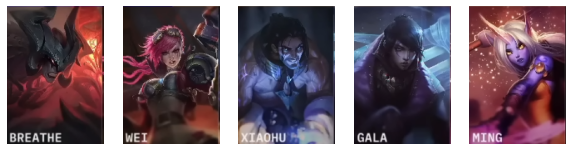

---------RED TEAM----------


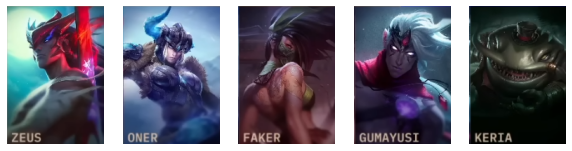

In [51]:
# Crop the champion image
blue_team = []
fig1, axs1 = plt.subplots(1,5, figsize=(10, 10))
print("--------BLUE TEAM-----------")
for i in range(5):
    champ = img[champ_y:, i*champ_x:champ_x*(i+1)]
    blue_team.append(champ)
    axs1[i].imshow(np.flip(champ, axis=-1))
    axs1[i].axis("off")
plt.show()
red_team = []
fig2, axs2 = plt.subplots(1,5, figsize=(10, 10))
print("---------RED TEAM----------")
for i in range(5):
    champ = img[champ_y:, red_team_x+i*champ_x:red_team_x+champ_x*(i+1)]
    red_team.append(champ)
    axs2[i].imshow(np.flip(champ, axis=-1))
    axs2[i].axis("off")
plt.show()

## Text Detection for PlayerID

We will be using Tesseract to identify the text. for more information got to: https://github.com/tesseract-ocr/tesseract#installing-tesseract

In [20]:
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
myconfig = r"--psm 11 --oem 1"

In [6]:
# Make image sharper for OCR
kernel = np.array([[0, -1, 0],
                  [-1, 5, -1],
                  [0, -1, 0]])

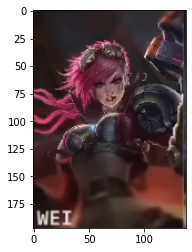

In [37]:
plt.imshow(np.flip(blue_team[1], axis=-1))

In [41]:
text = pytesseract.image_to_string(blue_team[1], config=myconfig)
print("Raw:", text)
print("Only upper cases:",re.sub('[^A-Z]', '', text))

Raw: 4

]

~ | all

Only upper cases: 


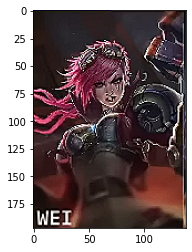

In [39]:
image_sharp = cv2.filter2D(src=blue_team[1], ddepth=-1, kernel=kernel)
plt.imshow(np.flip(image_sharp, axis=-1))

In [42]:
# set the tesseract path to the installation directory.
text = pytesseract.image_to_string(image_sharp, config=myconfig)
print("Raw:", text)
print("Only upper cases:",re.sub('[^A-Z]', '', text))

Raw: WEL

w

Only upper cases: WEL


## Champion Detection (Image recognition)

In [24]:
# Using tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [113]:
champ_folder = "./champ_img" # TODO: Download all the champion splash arts.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    champ_folder,
    labels="inferred",
    label_mode="int",
    image_size=(180, 180),
    shuffle=True,
    batch_size=11)

Found 11 files belonging to 11 classes.


In [115]:
# Use pretrained resnet50 model
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(180,180,3),
    pooling=None,classes=11,
    weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False
resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(128, activation='relu'))
resnet_model.add(Dense(11, activation='softmax'))

In [116]:
resnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 6, 6, 2048)        23587712  
_________________________________________________________________
flatten_4 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               9437312   
_________________________________________________________________
dense_9 (Dense)              (None, 11)                1419      
Total params: 33,026,443
Trainable params: 9,438,731
Non-trainable params: 23,587,712
_________________________________________________________________


In [117]:
resnet_model.compile(optimizer=Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [118]:
epochs=10
history = resnet_model.fit(
  train_ds,
  epochs=epochs
)

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 3.5827 - accuracy: 0.0909
Epoch 2/10
1/1 [==============================] - 0s 71ms/step - loss: 6.6344 - accuracy: 0.9091
Epoch 3/10
1/1 [==============================] - 0s 76ms/step - loss: 3.4438 - accuracy: 0.9091
Epoch 4/10
1/1 [==============================] - 0s 77ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 29ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/10
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/10
1/1 [==============================] - 0s 33ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 10/10
1/1 [==============================] - 0s 30ms/step - loss: 0.0000e+00 - accuracy: 1.0000


## Final Result

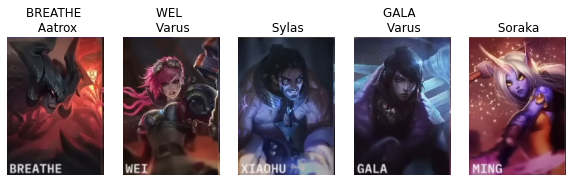

In [142]:
plt.figure(figsize=(10, 10))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(np.flip(blue_team[i], axis=-1))
    # Image recognition
    test_img = cv2.resize(blue_team[i], (180,180), interpolation = cv2.INTER_CUBIC)
    np_test_data = np.asarray(np.flip(test_img, axis=-1))
    np_final = np.expand_dims(np_test_data,axis=0)
    result = resnet_model.predict(np_final)
    output_class = train_ds.class_names[np.argmax(result)]
    # Text recognition
    image_sharp = cv2.filter2D(src=blue_team[i], ddepth=-1, kernel=kernel)
    raw_text = pytesseract.image_to_string(image_sharp, config=myconfig)
    name = re.sub('[^A-Z]', '', raw_text)
    plt.title(name+"\n"+output_class)
    plt.axis("off")

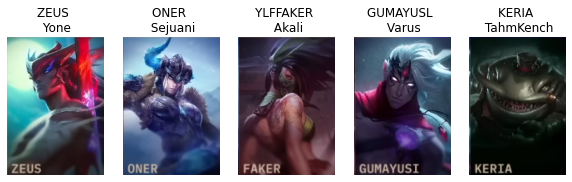

In [143]:
plt.figure(figsize=(10, 10))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(np.flip(red_team[i], axis=-1))
    # Image recognition
    test_img = cv2.resize(red_team[i], (180,180), interpolation = cv2.INTER_CUBIC)
    np_test_data = np.asarray(np.flip(test_img, axis=-1))
    np_final = np.expand_dims(np_test_data,axis=0)
    result = resnet_model.predict(np_final)
    output_class = train_ds.class_names[np.argmax(result)]
    # Text recognition
    image_sharp = cv2.filter2D(src=red_team[i], ddepth=-1, kernel=kernel)
    raw_text = pytesseract.image_to_string(image_sharp, config=myconfig)
    name = re.sub('[^A-Z]', '', raw_text)
    plt.title(name+"\n"+output_class)
    plt.axis("off")